# Przewidywanie Pogody na Podstawie Danych Historycznych

### Sieci Neuronowe 2024/2025  
**Hubert Malinowski, Maciej Karaśkiewicz**

---

### **Opis projektu**
Projekt skupia się na wykorzystaniu **sieci neuronowych** do przewidywania dwóch kluczowych aspektów pogody na podstawie danych historycznych z ostatnich trzech dni. Celem jest stworzenie modeli, które pozwolą na dokładniejsze prognozowanie warunków atmosferycznych z uwzględnieniem następujących parametrów:
1. **Średnia dzienna temperatura** – prognozowana z dokładnością do 2°C.
2. **Wystąpienie silnego wiatru** – definiowanego jako prędkość ≥6 m/s w ciągu dnia.

---

### **Wyzwania predykcyjne**
Istotnym wyzwaniem projektu jest konieczność przewidywania pogody na **dzień jutrzejszy (n+2)**, z pominięciem dnia dzisiejszego (n+1). Oznacza to, że dane wejściowe obejmują historyczne dane pogodowe z dni \(n-2\), \(n-1\) i \(n\), co wymaga od modelu umiejętności przewidywania z większym "wyprzedzeniem czasowym".

---

### **Cel projektu**
- Zbadanie wpływu różnych metod przetwarzania danych (np. normalizacja, agregacja) i architektur sieci neuronowych na skuteczność predykcji.
- Porównanie wyników modelu bazowego z wynikami uzyskanymi poprzez zastosowanie różnych hipotez badawczych, takich jak:
  - Wpływ normalizacji danych wejściowych.
  - Zastosowanie różnych funkcji aktywacji (ReLU, tanh).
  - Wykorzystanie oddzielnych sieci neuronowych do różnych zadań.

# 1. Budowanie modelu

W tej części projektu zostanie stworzony podstawowy model, który posłuży jako **punkt odniesienia** do porównywania wyników z testowanymi hipotezami.

Zaprojektowany model pozwoli na:
- Ocenę skuteczności w przewidywaniu temperatury i klasyfikacji wiatru.
- Zbadanie wpływu wprowadzanych zmian (hipotez) na wyniki w porównaniu z bazowym rozwiązaniem.

Model bazowy zostanie wykorzystany jako punkt wyjściowy do analizy, co umożliwi wyciągnięcie wniosków na temat efektywności poszczególnych modyfikacji.


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

## 1. Przygotowanie Danych

### 1.1. Wczytywanie Danych

Najpierw wczytujemy dane dotyczące temperatury i prędkości wiatru z plików CSV.


In [4]:
# Wczytywanie danych
temp = pd.read_csv("temperature.csv", parse_dates=['datetime'], index_col="datetime")
wind = pd.read_csv("wind_speed.csv", parse_dates=['datetime'], index_col="datetime")

### 1.2. Przekształcenie Danych do Formatu Długiego

Przekształcamy dane z formatu szerokiego (każde miasto jako osobna kolumna) na format długi, gdzie każda obserwacja zawiera `City`, `Date`, oraz odpowiadające wartości temperatury lub prędkości wiatru.


In [5]:
# Resetowanie indeksu, aby 'datetime' była kolumną
temp_reset = temp.reset_index()
wind_reset = wind.reset_index()

# Przekształcenie danych do formatu długiego
temp_long = temp_reset.melt(id_vars=['datetime'], var_name='City', value_name='Temperature_C')
wind_long = wind_reset.melt(id_vars=['datetime'], var_name='City', value_name='Wind_Speed_m_s')

### 1.3. Grupowanie i Agregacja Danych

Grupujemy dane dziennie i obliczamy średnie wartości temperatury oraz prędkości wiatru dla każdego miasta.


In [6]:
# Grupowanie dzienne i obliczanie średnich wartości dla każdego miasta
temp_daily = temp_long.copy()
temp_daily['Date'] = temp_daily['datetime'].dt.date
temp_daily = temp_daily.groupby(['City', 'Date']).mean().reset_index()

wind_daily = wind_long.copy()
wind_daily['Date'] = wind_daily['datetime'].dt.date
wind_daily = wind_daily.groupby(['City', 'Date']).mean().reset_index()

### 1.4. Łączenie Danych

Łączymy ramki danych dotyczące temperatury i wiatru na podstawie `City` i `Date`.


In [7]:
# Konwersja kolumny 'Date' na datetime
temp_daily['Date'] = pd.to_datetime(temp_daily['Date'])
wind_daily['Date'] = pd.to_datetime(wind_daily['Date'])

# Usunięcie kolumny 'datetime' po dodaniu 'Date'
temp_daily.drop('datetime', axis=1, inplace=True)
wind_daily.drop('datetime', axis=1, inplace=True)

# Sortowanie danych dla każdej grupy miast i dat
temp_daily = temp_daily.sort_values(['City', 'Date'])
wind_daily = wind_daily.sort_values(['City', 'Date'])

# Wypełnianie brakujących wartości metodą forward fill dla każdej grupy miasta
temp_daily[['Temperature_C']] = temp_daily.groupby('City')[['Temperature_C']].ffill()
wind_daily[['Wind_Speed_m_s']] = wind_daily.groupby('City')[['Wind_Speed_m_s']].ffill()

# Klasyfikowanie wiatru na silny (1) i słaby (0)
wind_daily['Strong_Wind'] = (wind_daily['Wind_Speed_m_s'] >= 6).astype(int)

# Łączenie ramek danych temp_daily i wind_daily na podstawie 'City' i 'Date'
daily_data = pd.merge(
    temp_daily,
    wind_daily[['City', 'Date', 'Wind_Speed_m_s', 'Strong_Wind']],
    on=['City', 'Date'],
    how='inner'
)

# Sprawdzenie połączonej ramki danych
print("\nKolumny w połączonej ramce danych 'daily_data':", daily_data.columns)
print(daily_data.head())


Kolumny w połączonej ramce danych 'daily_data': Index(['City', 'Date', 'Temperature_C', 'Wind_Speed_m_s', 'Strong_Wind'], dtype='object')
          City       Date  Temperature_C  Wind_Speed_m_s  Strong_Wind
0  Albuquerque 2012-10-01     285.476208        4.000000            0
1  Albuquerque 2012-10-02     289.771821        3.166667            0
2  Albuquerque 2012-10-03     291.205417        2.958333            0
3  Albuquerque 2012-10-04     293.096250        1.916667            0
4  Albuquerque 2012-10-05     292.829167        2.583333            0


### 1.5. Tworzenie Oddzielnych Ramkek Danych dla Każdego Miasta

Tworzymy słownik `city_dfs`, gdzie klucze to nazwy miast, a wartościami są odpowiadające im ramki danych.


In [8]:
# Tworzenie słownika z oddzielnymi ramkami danych dla każdego miasta
city_dfs = {city: df.reset_index(drop=True) for city, df in daily_data.groupby('City')}

# Sprawdzenie przykładowego miasta
print("\nPrzykładowa ramka danych dla Vancouver:")
print(city_dfs['Vancouver'].head())


Przykładowa ramka danych dla Vancouver:
        City       Date  Temperature_C  Wind_Speed_m_s  Strong_Wind
0  Vancouver 2012-10-01     284.620769        0.000000            0
1  Vancouver 2012-10-02     286.145190        0.000000            0
2  Vancouver 2012-10-03     285.528125        0.541667            0
3  Vancouver 2012-10-04     284.373333        0.625000            0
4  Vancouver 2012-10-05     283.757292        0.416667            0


## 2. Tworzenie Okien Przewidywania

### 2.1. Definicja Funkcji `create_windows`

Definiujemy funkcję, która tworzy okna danych (ang. sliding windows) z ostatnich `window_size` dni, przygotowując cechy (`X`) oraz etykiety (`y_temp`, `y_wind`).


In [9]:
# Definicja funkcji tworzącej okno przewidywania
def create_windows(df, window_size=3, skip=1):
    X = []
    y_temp = []
    y_wind = []

    for i in range(window_size, len(df) - skip + 1):
        # Sprawdzenie czy dni są kolejne
        window = df.iloc[i-window_size:i]
        target = df.iloc[i + skip -1]

        # Sprawdzenie, czy dni są ciągłe
        expected_date = window['Date'].iloc[-1] + pd.Timedelta(days=1)
        if target['Date'] != expected_date:
            continue

        # Przygotowanie cech
        features = window[['Temperature_C', 'Wind_Speed_m_s']].values.flatten()
        X.append(features)
        y_temp.append(target['Temperature_C'])
        y_wind.append(target['Strong_Wind'])

    return np.array(X), np.array(y_temp), np.array(y_wind)

### 2.2. Tworzenie Okien Przewidywania dla Każdego Miasta

Tworzymy okna przewidywania dla każdego miasta i przechowujemy je w słowniku `windows_dfs`.


In [10]:
# Tworzenie okien przewidywania dla każdego miasta i przechowywanie w słowniku
windows_dfs = {}
for city, df in city_dfs.items():
    X, y_temp, y_wind = create_windows(df, window_size=3, skip=1)
    windows_dfs[city] = {
        'X': X,
        'y_temp': y_temp,
        'y_wind': y_wind
    }

### 2.3. Podział i Normalizacja Danych

Dla każdego miasta dzielimy dane na zestawy treningowe, walidacyjne i testowe oraz przeprowadzamy normalizację cech wejściowych.


In [11]:
# Podział danych na zestawy treningowe, walidacyjne i testowe oraz normalizacja
for city, data in windows_dfs.items():
    X = data['X']
    y_temp = data['y_temp']
    y_wind = data['y_wind']

    # Podział danych na zestaw treningowy, walidacyjny i testowy
    X_train, X_temp_split, y_temp_train, y_temp_temp_split, y_wind_train, y_wind_temp_split = train_test_split(
        X, y_temp, y_wind, test_size=0.3, random_state=42, shuffle=True
    )

    X_val, X_test, y_temp_val, y_temp_test, y_wind_val, y_wind_test = train_test_split(
        X_temp_split, y_temp_temp_split, y_wind_temp_split, test_size=0.5, random_state=42, shuffle=True
    )

    # Normalizacja cech wejściowych
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Przekształcenie danych na tensory
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_temp_train_tensor = torch.tensor(y_temp_train, dtype=torch.float32)
    y_wind_train_tensor = torch.tensor(y_wind_train, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_temp_val_tensor = torch.tensor(y_temp_val, dtype=torch.float32)
    y_wind_val_tensor = torch.tensor(y_wind_val, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_temp_test_tensor = torch.tensor(y_temp_test, dtype=torch.float32)
    y_wind_test_tensor = torch.tensor(y_wind_test, dtype=torch.float32)

    # Aktualizacja słownika z normalizowanymi danymi i tensorami
    windows_dfs[city]['X_train'] = X_train_tensor
    windows_dfs[city]['X_val'] = X_val_tensor
    windows_dfs[city]['X_test'] = X_test_tensor
    windows_dfs[city]['y_temp_train'] = y_temp_train_tensor
    windows_dfs[city]['y_temp_val'] = y_temp_val_tensor
    windows_dfs[city]['y_temp_test'] = y_temp_test_tensor
    windows_dfs[city]['y_wind_train'] = y_wind_train_tensor
    windows_dfs[city]['y_wind_val'] = y_wind_val_tensor
    windows_dfs[city]['y_wind_test'] = y_wind_test_tensor
    windows_dfs[city]['scaler'] = scaler

## 3. Definicja Modelu

Definiujemy model sieci neuronowej, który będzie przewidywał temperaturę oraz klasyfikował siłę wiatru.


In [38]:
class WeatherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_temp, output_size_wind):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_temp = nn.Linear(hidden_size, output_size_temp)  # Dla temperatury (regresja)
        self.fc2_wind = nn.Linear(hidden_size, output_size_wind)  # Dla wiatru (klasyfikacja)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        temp = self.fc2_temp(out)
        wind = self.sigmoid(self.fc2_wind(out))
        return temp, wind

## 4. Trenowanie Modelu

### Definicja Funkcji Trenowania

Definiujemy funkcję, która będzie odpowiadać za trenowanie modelu.


In [39]:
# Definicja funkcji trenowania modelu
def train_model(model, X_train, y_temp_train, y_wind_train,
               X_val, y_temp_val, y_wind_val,
               criterion_temp, criterion_wind, optimizer,
               num_epochs=100):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs_temp, outputs_wind = model(X_train)

        loss_temp = criterion_temp(outputs_temp.squeeze(), y_temp_train)
        loss_wind = criterion_wind(outputs_wind.squeeze(), y_wind_train)

        loss = loss_temp + loss_wind
        loss.backward()
        optimizer.step()

        # Walidacja
        model.eval()
        with torch.no_grad():
            val_outputs_temp, val_outputs_wind = model(X_val)
            val_loss_temp = criterion_temp(val_outputs_temp.squeeze(), y_temp_val)
            val_loss_wind = criterion_wind(val_outputs_wind.squeeze(), y_wind_val)
            val_loss = val_loss_temp + val_loss_wind

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return history

### 4.1. Trenowanie Modelu dla Vancouver

Trenujemy model dla wybranego miasta (Vancouver).


In [14]:
# Trenowanie modelu dla Vancouver
city = 'Vancouver'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [100/5000], Loss: 12960.9863, Val Loss: 13160.0869
Epoch [200/5000], Loss: 4910.3726, Val Loss: 5172.0557
Epoch [300/5000], Loss: 1892.5337, Val Loss: 2075.0354
Epoch [400/5000], Loss: 541.5464, Val Loss: 641.7428
Epoch [500/5000], Loss: 193.2115, Val Loss: 251.1435
Epoch [600/5000], Loss: 82.4945, Val Loss: 119.1482
Epoch [700/5000], Loss: 41.8197, Val Loss: 66.0715
Epoch [800/5000], Loss: 23.9118, Val Loss: 40.6217
Epoch [900/5000], Loss: 15.2010, Val Loss: 27.1062
Epoch [1000/5000], Loss: 10.5442, Val Loss: 19.3120
Epoch [1100/5000], Loss: 7.8462, Val Loss: 14.5986
Epoch [1200/5000], Loss: 6.1741, Val Loss: 11.6095
Epoch [1300/5000], Loss: 5.0750, Val Loss: 9.4416
Epoch [1400/5000], Loss: 4.3348, Val Loss: 7.8394
Epoch [1500/5000], Loss: 3.8144, Val Loss: 6.6124
Epoch [1600/5000], Loss: 3.4471, Val Loss: 5.7127
Epoch [1700/5000], Loss: 3.1705, Val Loss: 5.0379
Epoch [1800/5000], Loss: 2.9638, Val Loss: 4.5007
Epoch [1900/5000], Loss: 2.8043, Val Loss: 4.0775
Epoch [2000/5000],

#### Generowanie wizualizacji Modelu dla Vancouver

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta Vancouver.

In [15]:
# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


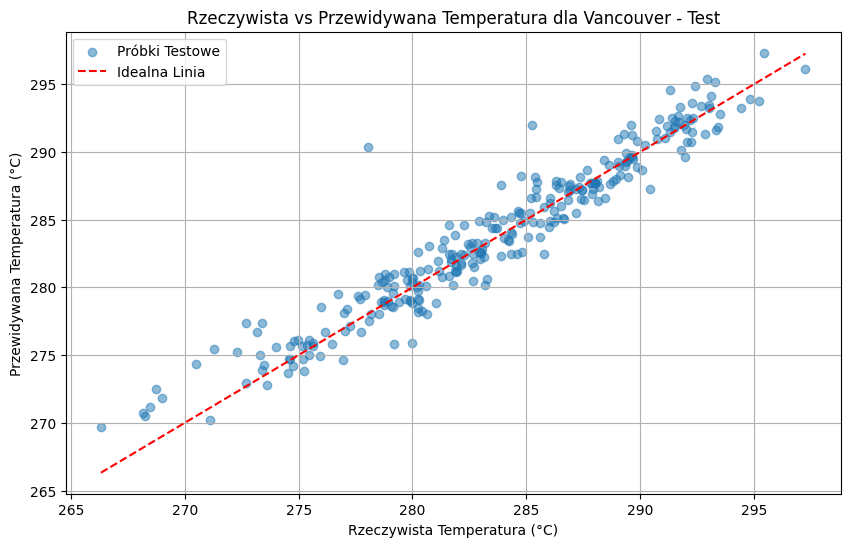

In [16]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla Vancouver - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


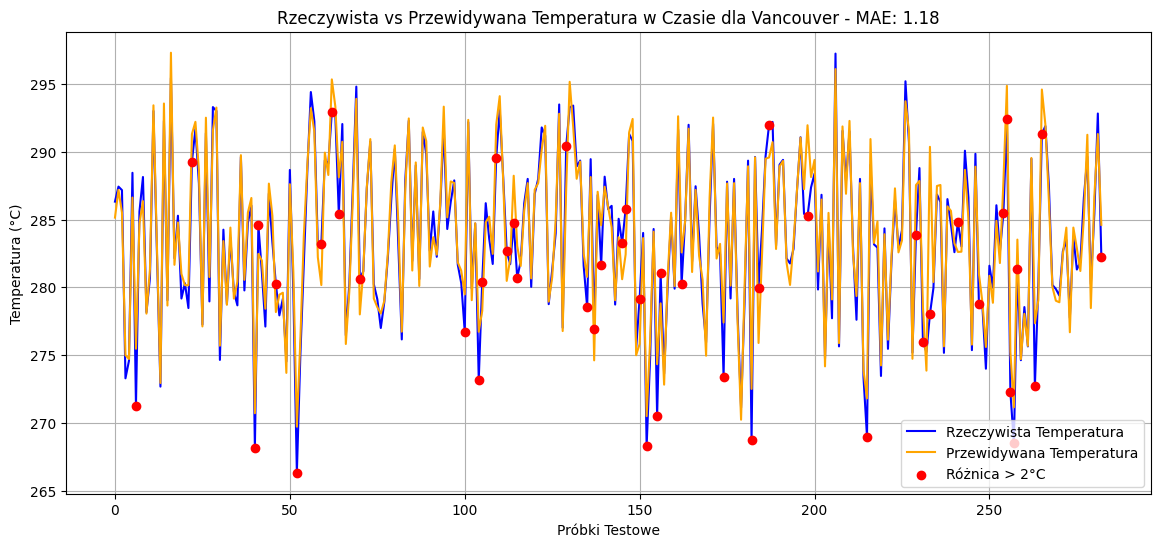

In [17]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura w Czasie dla Vancouver - MAE: {round(sum(differences)/len(differences), 2)}')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


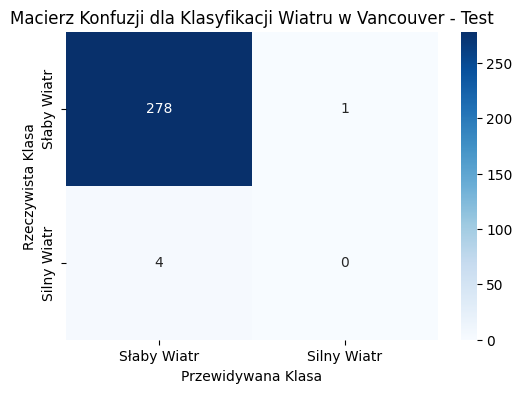

In [18]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w Vancouver - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [19]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w Vancouver - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr'], zero_division=0), )

Raport Klasyfikacji dla Wiatru w Vancouver - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.99      1.00      0.99       279
 Silny Wiatr       0.00      0.00      0.00         4

    accuracy                           0.98       283
   macro avg       0.49      0.50      0.50       283
weighted avg       0.97      0.98      0.98       283



3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


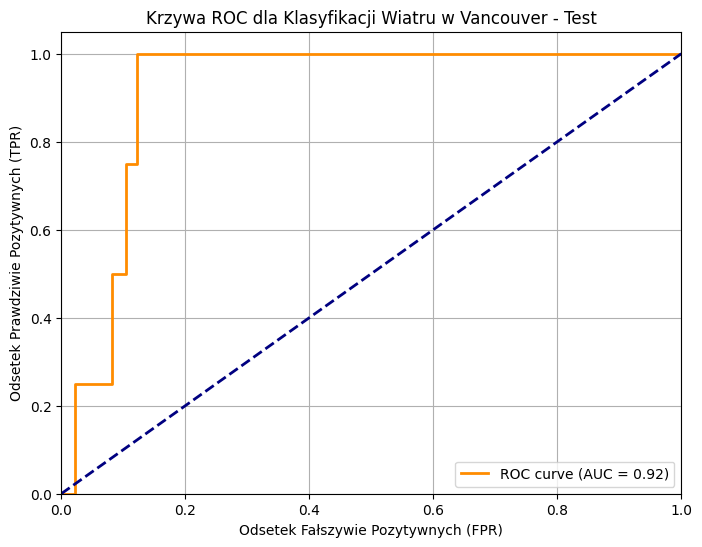

In [20]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w Vancouver - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.2. Trenowanie Modelu dla Eilat

Trenujemy model dla wybranego miasta (Eilat).


In [21]:
# Trenowanie modelu dla Eilat
city = 'Eilat'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()  # Używamy BCELoss z sigmoid w modelu

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [100/5000], Loss: 14904.7363, Val Loss: 13344.7705
Epoch [200/5000], Loss: 5812.2563, Val Loss: 5166.6079
Epoch [300/5000], Loss: 1401.0934, Val Loss: 1287.3512
Epoch [400/5000], Loss: 421.5801, Val Loss: 393.3552
Epoch [500/5000], Loss: 178.7284, Val Loss: 166.3889
Epoch [600/5000], Loss: 89.1467, Val Loss: 82.7557
Epoch [700/5000], Loss: 48.4162, Val Loss: 45.4673
Epoch [800/5000], Loss: 28.7353, Val Loss: 27.1819
Epoch [900/5000], Loss: 18.9016, Val Loss: 17.8071
Epoch [1000/5000], Loss: 13.4144, Val Loss: 12.5920
Epoch [1100/5000], Loss: 9.8796, Val Loss: 9.2861
Epoch [1200/5000], Loss: 7.5752, Val Loss: 7.1403
Epoch [1300/5000], Loss: 6.1031, Val Loss: 5.7143
Epoch [1400/5000], Loss: 5.1623, Val Loss: 4.8041
Epoch [1500/5000], Loss: 4.5616, Val Loss: 4.2030
Epoch [1600/5000], Loss: 4.1679, Val Loss: 3.7926
Epoch [1700/5000], Loss: 3.8998, Val Loss: 3.5125
Epoch [1800/5000], Loss: 3.7042, Val Loss: 3.3030
Epoch [1900/5000], Loss: 3.5687, Val Loss: 3.1618
Epoch [2000/5000], Lo

#### Generowanie wizualizacji Modelu dla Eilat

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta Eilat.

In [22]:
# Wizualizacje dla Eilat
city = 'Eilat'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


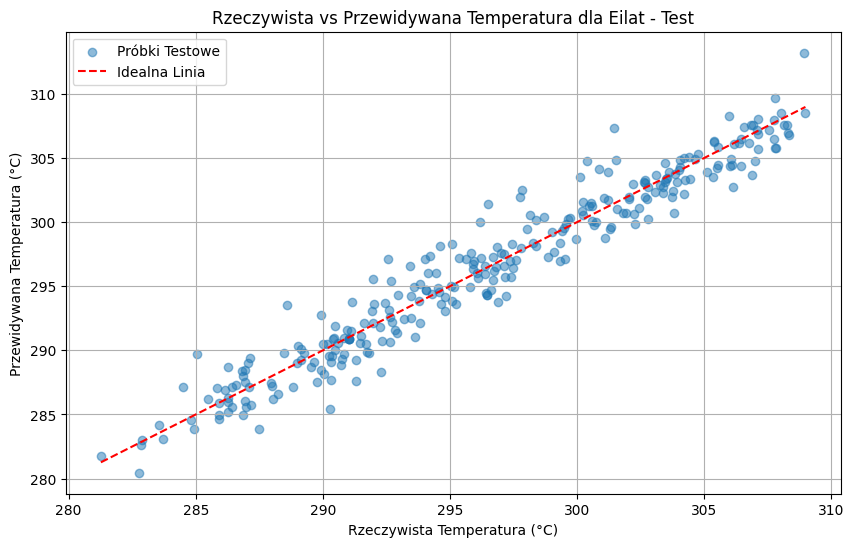

In [23]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla Eilat - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


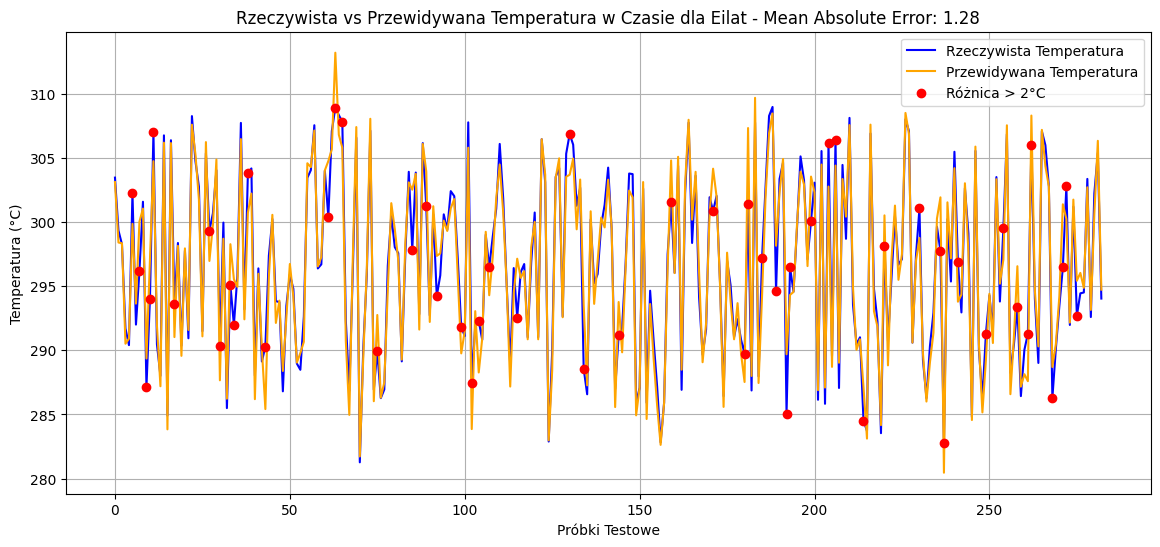

In [24]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura w Czasie dla Eilat - Mean Absolute Error: {round(sum(differences)/len(differences), 2)}')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


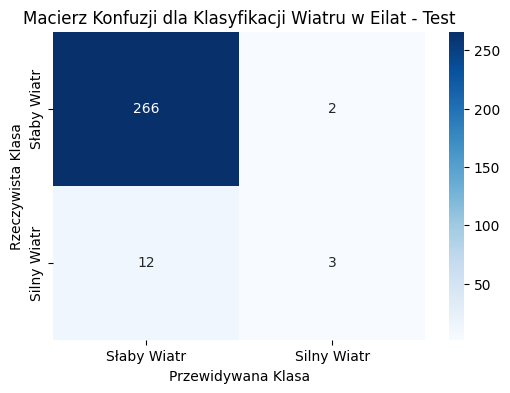

In [25]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w Eilat - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [26]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w Eilat - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr'], zero_division=0))

Raport Klasyfikacji dla Wiatru w Eilat - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.96      0.99      0.97       268
 Silny Wiatr       0.60      0.20      0.30        15

    accuracy                           0.95       283
   macro avg       0.78      0.60      0.64       283
weighted avg       0.94      0.95      0.94       283



3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


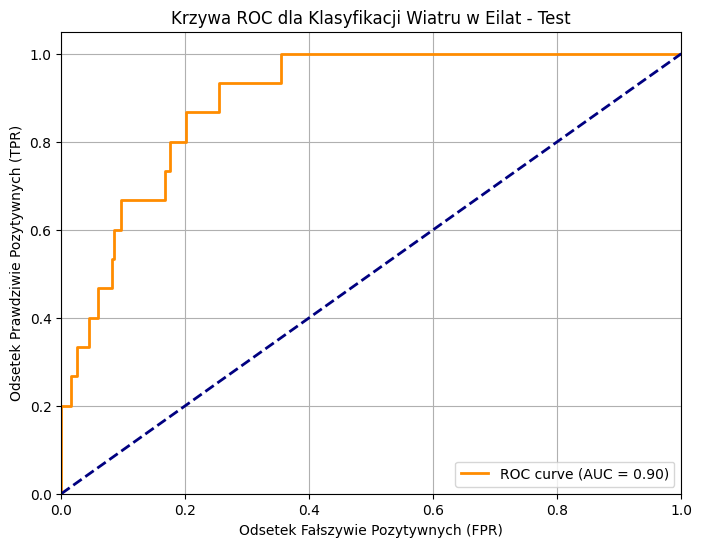

In [27]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w Eilat - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.3. Trenowanie Modelu dla New York

Trenujemy model dla wybranego miasta (New York).


In [28]:
# Trenowanie modelu dla New York
city = 'New York'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()  # Używamy BCELoss z sigmoid w modelu

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

Epoch [100/5000], Loss: 79593.5000, Val Loss: 79941.4922
Epoch [200/5000], Loss: 75324.7734, Val Loss: 75680.1406
Epoch [300/5000], Loss: 67684.3984, Val Loss: 68060.1875
Epoch [400/5000], Loss: 57137.8633, Val Loss: 57507.6836
Epoch [500/5000], Loss: 45374.1758, Val Loss: 45655.2969
Epoch [600/5000], Loss: 34384.4102, Val Loss: 34470.8359
Epoch [700/5000], Loss: 25455.2598, Val Loss: 25257.7461
Epoch [800/5000], Loss: 19110.9531, Val Loss: 18604.7188
Epoch [900/5000], Loss: 15106.2275, Val Loss: 14335.0410
Epoch [1000/5000], Loss: 12766.6260, Val Loss: 11815.6074
Epoch [1100/5000], Loss: 11386.2324, Val Loss: 10342.9395
Epoch [1200/5000], Loss: 10465.9570, Val Loss: 9396.7354
Epoch [1300/5000], Loss: 9719.6123, Val Loss: 8673.6416
Epoch [1400/5000], Loss: 9025.8691, Val Loss: 8031.5576
Epoch [1500/5000], Loss: 8349.1094, Val Loss: 7418.0293
Epoch [1600/5000], Loss: 7678.7993, Val Loss: 6815.2666
Epoch [1700/5000], Loss: 7007.4316, Val Loss: 6212.1597
Epoch [1800/5000], Loss: 6335.0054

#### Generowanie wizualizacji Modelu dla New York

Generujemy różne wizualizacje, aby ocenić wydajność modelu na danych testowych dla miasta New York.

In [29]:
# Wizualizacje dla New York
city = 'New York'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

##### A. Wizualizacja dla Temperatury

1. **Scatter Plot Rzeczywista vs Przewidywana Temperatura**

Tworzymy wykres punktowy porównujący rzeczywiste wartości temperatury z przewidywanymi przez model.


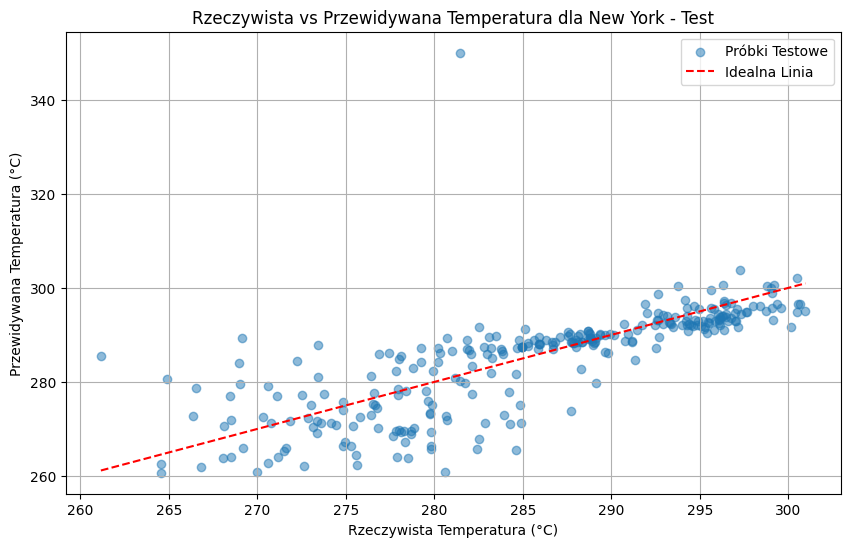

In [30]:
# Scatter Plot Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(10,6))
plt.scatter(y_temp_test_np, outputs_temp_test_np, alpha=0.5, label='Próbki Testowe')
plt.plot([y_temp_test_np.min(), y_temp_test_np.max()], [y_temp_test_np.min(), y_temp_test_np.max()], 'r--', label='Idealna Linia')
plt.xlabel('Rzeczywista Temperatura (°C)')
plt.ylabel('Przewidywana Temperatura (°C)')
plt.title('Rzeczywista vs Przewidywana Temperatura dla New York - Test')
plt.legend()
plt.grid(True)
plt.show()

2. **Wykres Temperatura w Czasie**

Porównujemy rzeczywiste i przewidywane temperatury w kolejności próbek testowych, aby zobaczyć trend i zgodność modelu z rzeczywistością.


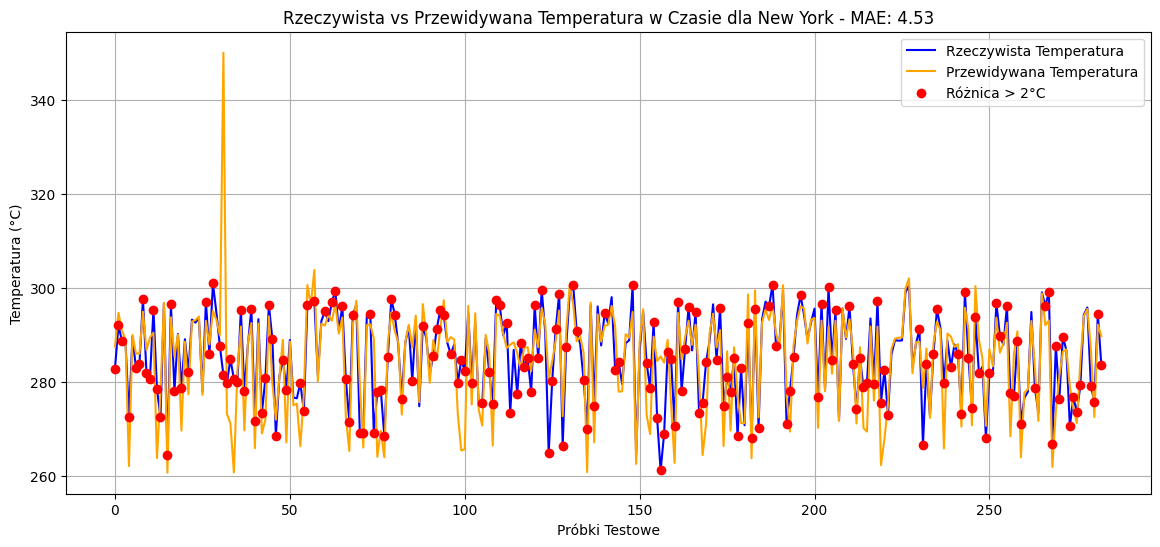

In [31]:
# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura w Czasie dla New York - MAE: {round(sum(differences)/len(differences), 2)}')
plt.legend()
plt.grid(True)
plt.show()

##### B. Wizualizacja dla Klasyfikacji Wiatru

1. **Macierz Konfuzji**

Tworzymy macierz konfuzji, aby zobaczyć, ile razy model prawidłowo klasyfikował silny i słaby wiatr oraz ile błędnie.


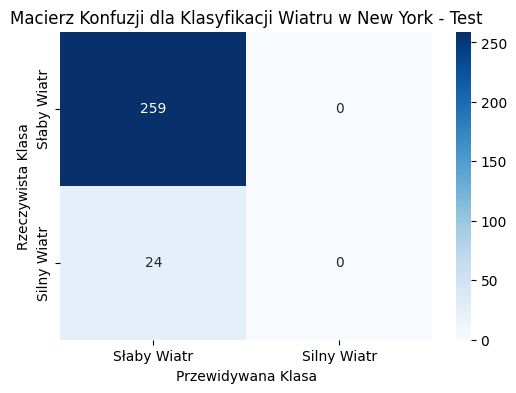

In [32]:
# Macierz Konfuzji
cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Słaby Wiatr', 'Silny Wiatr'], yticklabels=['Słaby Wiatr', 'Silny Wiatr'])
plt.xlabel('Przewidywana Klasa')
plt.ylabel('Rzeczywista Klasa')
plt.title('Macierz Konfuzji dla Klasyfikacji Wiatru w New York - Test')
plt.show()

2. **Raport Klasyfikacji**

Wyświetlamy raport klasyfikacji, który zawiera precyzję, czułość, F1-score oraz inne metryki dla każdej klasy.


In [33]:
# Raport Klasyfikacji
print("Raport Klasyfikacji dla Wiatru w New York - Test:")
print(classification_report(y_wind_test_np, y_wind_pred_np, target_names=['Słaby Wiatr', 'Silny Wiatr'], zero_division=0))

Raport Klasyfikacji dla Wiatru w New York - Test:
              precision    recall  f1-score   support

 Słaby Wiatr       0.92      1.00      0.96       259
 Silny Wiatr       0.00      0.00      0.00        24

    accuracy                           0.92       283
   macro avg       0.46      0.50      0.48       283
weighted avg       0.84      0.92      0.87       283



3. **Krzywa ROC i AUC**

Tworzymy krzywą ROC oraz obliczamy AUC, aby ocenić zdolność modelu do rozróżnienia między klasami w różnych progach decyzyjnych.


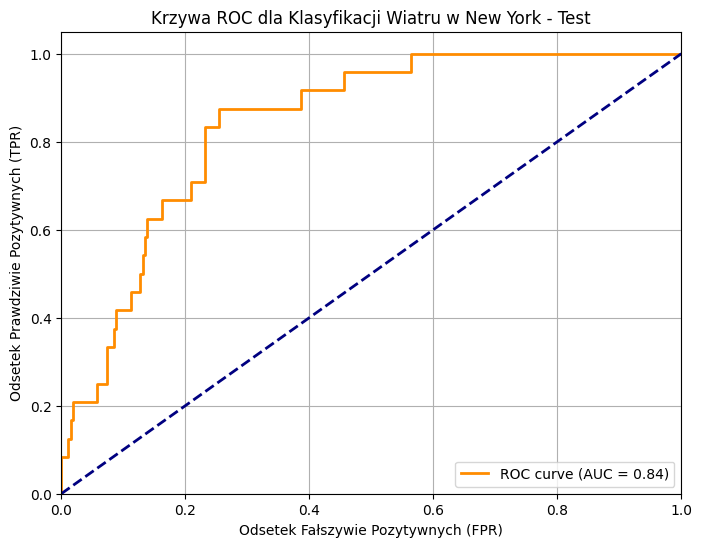

In [34]:
# Krzywa ROC i AUC
fpr, tpr, thresholds = roc_curve(y_wind_test_np, outputs_wind_test_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
plt.ylabel('Odsetek Prawdziwie Pozytywnych (TPR)')
plt.title('Krzywa ROC dla Klasyfikacji Wiatru w New York - Test')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 2. Hipotezy Badawcze

Aby odpowiedzieć na kluczowe pytania badawcze i ocenić różne aspekty wpływające na skuteczność modelu, hipotezy zostały podzielone na cztery główne kategorie. Każda kategoria koncentruje się na innej części procesu tworzenia i trenowania sieci neuronowych:

---

### **Kodowanie danych**
Celem tej kategorii jest zbadanie, w jaki sposób różne metody przetwarzania i przygotowania danych wpływają na skuteczność modelu. Rozważane podejścia obejmują:
- Normalizację danych wejściowych do przedziału [-1, 1] w celu poprawy stabilności i szybkości uczenia.
- Przetwarzanie surowych danych bez żadnych przekształceń, aby ocenić, czy model jest w stanie nauczyć się efektywnie z oryginalnych danych.
---

### **Architektura sieci**
Ta sekcja dotyczy różnych podejść do projektowania struktury modelu. Hipotezy obejmują:
- Porównanie skuteczności pojedynczej sieci realizującej równocześnie zadanie regresji (temperatura) i klasyfikacji (wiatr) z dwiema oddzielnymi sieciami, każdą dedykowaną jednemu zadaniu.

---

### **Architektura sieci dla danych znormalizowanych**
W tej kategorii sprawdzane są hipotezy związane z efektywnością sieci neuronowych trenowanych na znormalizowanych danych wejściowych. W szczególności badane są:
- Wpływ normalizacji danych na poprawę stabilności procesu uczenia.
- Ocena, czy sieci działające na znormalizowanych danych osiągają szybszą zbieżność niż sieci na danych surowych.

---

### **Funkcje aktywacji**
Hipotezy w tej kategorii koncentrują się na roli funkcji aktywacji w procesie uczenia modelu. Analizowane scenariusze obejmują:
- Porównanie funkcji **ReLU** i **tanh** w warstwach ukrytych.

---

Kod implementujący i weryfikujący każdą hipotezę znajduje się bezpośrednio pod sekcjami odpowiadającymi danym hipotezom. Każda sekcja zawiera szczegółowy opis eksperymentu, wyniki oraz wnioski, co pozwala na łatwe porównanie różnych podejść i wyciągnięcie wniosków na temat ich skuteczności. Wszystkie badania zostały przeprowadzone dla miasta "Vancouver".


## 2.1 Kodowanie danych

**Hipoteza**
Normalizacja danych wejściowych do przedziału [-1, 1] poprawi skuteczność uczenia w porównaniu do surowych danych.

**Opis**
W pierwotnym podejściu dane wejściowe zostały znormalizowane do przedziału [-1, 1] przy użyciu standardowych metod skalowania. Aby ocenić wpływ normalizacji na efektywność modelu, przeprowadzono eksperyment, w którym dane wejściowe pozostawiono w ich pierwotnej, nieprzetworzonej postaci. Porównano wyniki modeli trenujących się na danych znormalizowanych i nieznormalizowanych, analizując zarówno regresję temperatury, jak i klasyfikację wiatru.

**Wnioski**
1. **Temperatura (regresja):**  
   Normalizacja danych nie miała znaczącego wpływu na jakość przewidywań temperatury. Modele znormalizowane i nieznormalizowane osiągnęły bardzo zbliżony poziom błędu średniego (MAE).

2. **Wiatr (klasyfikacja):**  
   Wyniki klasyfikacji wiatru były gorsze dla danych nieznormalizowanych. Macierz konfuzji wskazuje na trudności modelu w rozpoznawaniu klasy „silny wiatr” przy braku normalizacji.


Epoch [100/5000], Loss: 7.7511, Val Loss: 8.8711
Epoch [200/5000], Loss: 5.9185, Val Loss: 6.8726
Epoch [300/5000], Loss: 5.7839, Val Loss: 6.7061
Epoch [400/5000], Loss: 5.6516, Val Loss: 6.5375
Epoch [500/5000], Loss: 5.5315, Val Loss: 6.3800
Epoch [600/5000], Loss: 5.4288, Val Loss: 6.2401
Epoch [700/5000], Loss: 5.3449, Val Loss: 6.1204
Epoch [800/5000], Loss: 5.2786, Val Loss: 6.0210
Epoch [900/5000], Loss: 5.2275, Val Loss: 5.9399
Epoch [1000/5000], Loss: 5.1884, Val Loss: 5.8743
Epoch [1100/5000], Loss: 5.1583, Val Loss: 5.8212
Epoch [1200/5000], Loss: 5.1343, Val Loss: 5.7779
Epoch [1300/5000], Loss: 5.1143, Val Loss: 5.7419
Epoch [1400/5000], Loss: 5.0966, Val Loss: 5.7111
Epoch [1500/5000], Loss: 5.0801, Val Loss: 5.6840
Epoch [1600/5000], Loss: 5.0641, Val Loss: 5.6594
Epoch [1700/5000], Loss: 5.0480, Val Loss: 5.6363
Epoch [1800/5000], Loss: 5.0316, Val Loss: 5.6142
Epoch [1900/5000], Loss: 5.0147, Val Loss: 5.5925
Epoch [2000/5000], Loss: 4.9973, Val Loss: 5.5709
Epoch [21

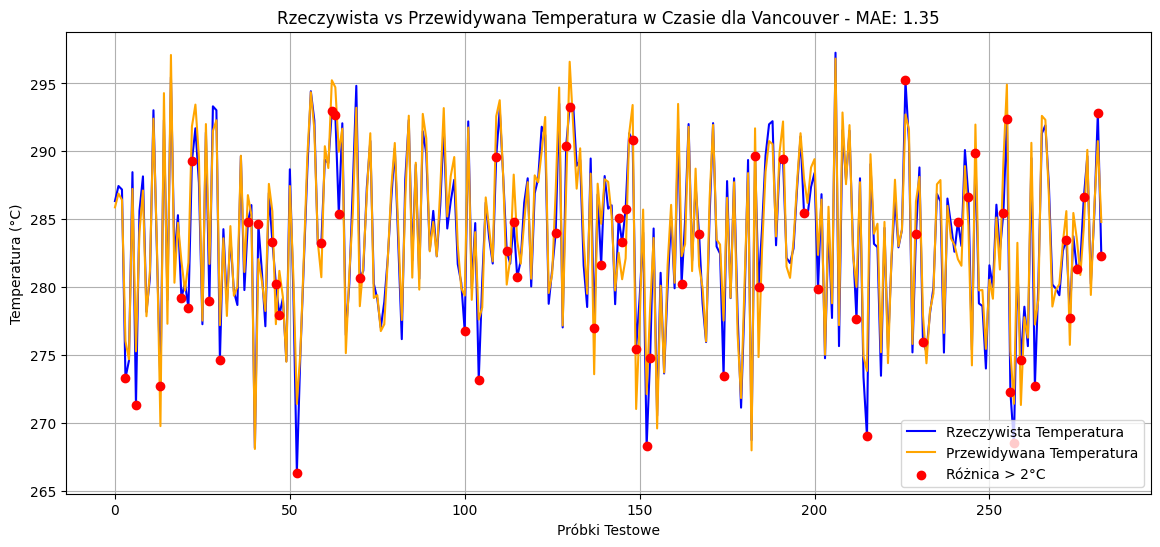

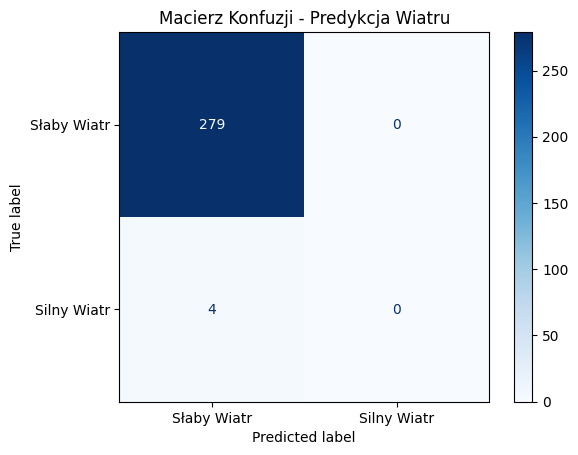

In [40]:
# Podział danych na zestawy treningowe, walidacyjne i testowe bez normalizacji
for city, data in windows_dfs.items():
    X = data['X']
    y_temp = data['y_temp']
    y_wind = data['y_wind']

    # Podział danych na zestaw treningowy, walidacyjny i testowy
    X_train, X_temp_split, y_temp_train, y_temp_temp_split, y_wind_train, y_wind_temp_split = train_test_split(
        X, y_temp, y_wind, test_size=0.3, random_state=42, shuffle=True
    )

    X_val, X_test, y_temp_val, y_temp_test, y_wind_val, y_wind_test = train_test_split(
        X_temp_split, y_temp_temp_split, y_wind_temp_split, test_size=0.5, random_state=42, shuffle=True
    )

    # Przekształcenie danych na tensory (bez normalizacji)
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_temp_train_tensor = torch.tensor(y_temp_train, dtype=torch.float32)
    y_wind_train_tensor = torch.tensor(y_wind_train, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_temp_val_tensor = torch.tensor(y_temp_val, dtype=torch.float32)
    y_wind_val_tensor = torch.tensor(y_wind_val, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_temp_test_tensor = torch.tensor(y_temp_test, dtype=torch.float32)
    y_wind_test_tensor = torch.tensor(y_wind_test, dtype=torch.float32)

    # Aktualizacja słownika z danymi i tensorami
    windows_dfs[city]['X_train'] = X_train_tensor
    windows_dfs[city]['X_val'] = X_val_tensor
    windows_dfs[city]['X_test'] = X_test_tensor
    windows_dfs[city]['y_temp_train'] = y_temp_train_tensor
    windows_dfs[city]['y_temp_val'] = y_temp_val_tensor
    windows_dfs[city]['y_temp_test'] = y_temp_test_tensor
    windows_dfs[city]['y_wind_train'] = y_wind_train_tensor
    windows_dfs[city]['y_wind_val'] = y_wind_val_tensor
    windows_dfs[city]['y_wind_test'] = y_wind_test_tensor

# Trenowanie modelu dla Vancouver
city = 'Vancouver'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura w Czasie dla Vancouver - MAE: {round(sum(differences)/len(differences), 2)}')
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja: Macierz konfuzji dla klasyfikacji wiatru
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Słaby Wiatr', 'Silny Wiatr'])

disp.plot(cmap='Blues', values_format='d')
plt.title('Macierz Konfuzji - Predykcja Wiatru')
plt.show()

## 2.2 Architektura Sieci

**Hipoteza**
Wykorzystanie oddzielnych sieci dla predykcji temperatury i wiatru zapewni lepsze wyniki niż pojedyncza sieć.

**Opis**
Zastosowano dwie niezależne sieci:
1. **Model temperatury (regresja)**: przewiduje rzeczywistą wartość temperatury, wykorzystując funkcję straty **MSELoss**.
2. **Model wiatru (klasyfikacja)**: przewiduje prawdopodobieństwo silnego wiatru, używając funkcji aktywacji **sigmoid** oraz straty **BCELoss**.

Oba modele były trenowane osobno, a wyniki zaprezentowano jako:
- Wykres rzeczywistych i przewidywanych temperatur (z MAE i punktami o dużych różnicach).
- Macierz konfuzji dla wiatru.

**Wnioski**
1. **Temperatura**: Oddzielny model dla temperatury dał wyniki porównywalne do pojedynczej sieci, z akceptowalnym poziomem błędu (MAE). Rozdzielenie zadań nie wpłynęło znacząco na jakość przewidywań.
2. **Wiatr**: Model klasyfikacyjny miał trudności z rozróżnianiem słabego i silnego wiatru. Wyniki sugerują:
   - Możliwy brak równowagi klas (niedostateczna liczba próbek dla „silnego wiatru”).
   - Niewystarczającą ilość informacji w cechach wejściowych.


Epoch [100/5000]
  Train Loss - Temp: 4.8896, Wind: 0.9935
  Val Loss   - Temp: 5.4964, Wind: 1.3644
Epoch [200/5000]
  Train Loss - Temp: 4.6662, Wind: 0.9935
  Val Loss   - Temp: 5.3293, Wind: 1.3644
Epoch [300/5000]
  Train Loss - Temp: 4.5387, Wind: 0.9935
  Val Loss   - Temp: 5.1522, Wind: 1.3644
Epoch [400/5000]
  Train Loss - Temp: 4.4280, Wind: 0.9935
  Val Loss   - Temp: 4.9898, Wind: 1.3644
Epoch [500/5000]
  Train Loss - Temp: 4.3409, Wind: 0.9935
  Val Loss   - Temp: 4.8531, Wind: 1.3644
Epoch [600/5000]
  Train Loss - Temp: 4.2769, Wind: 0.9935
  Val Loss   - Temp: 4.7442, Wind: 1.3644
Epoch [700/5000]
  Train Loss - Temp: 4.2317, Wind: 0.9935
  Val Loss   - Temp: 4.6601, Wind: 1.3644
Epoch [800/5000]
  Train Loss - Temp: 4.1998, Wind: 0.9935
  Val Loss   - Temp: 4.5959, Wind: 1.3644
Epoch [900/5000]
  Train Loss - Temp: 4.1763, Wind: 0.9935
  Val Loss   - Temp: 4.5466, Wind: 1.3644
Epoch [1000/5000]
  Train Loss - Temp: 4.1575, Wind: 0.9935
  Val Loss   - Temp: 4.5076, Wi

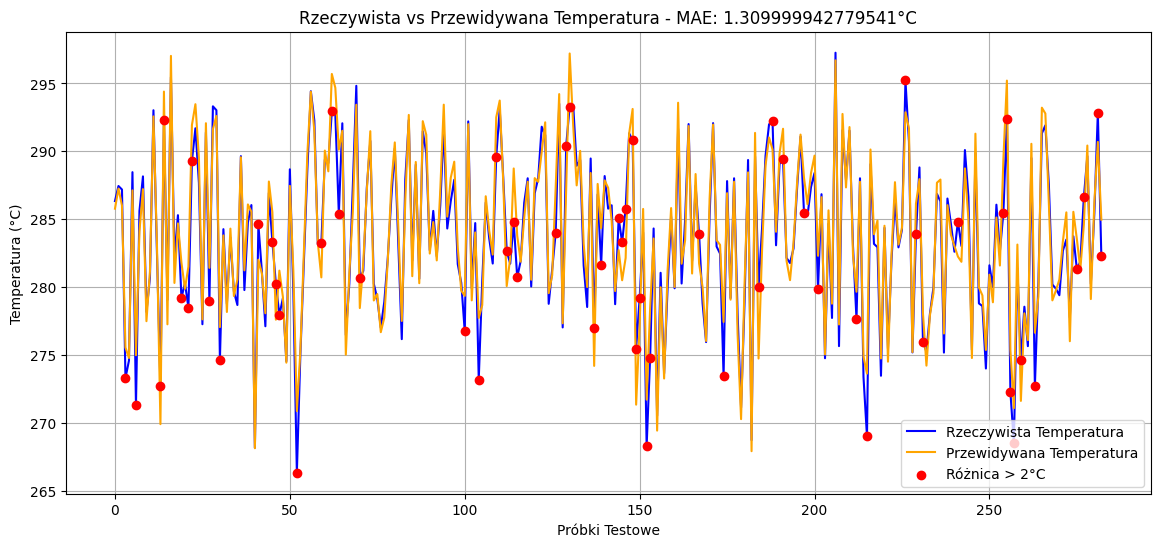

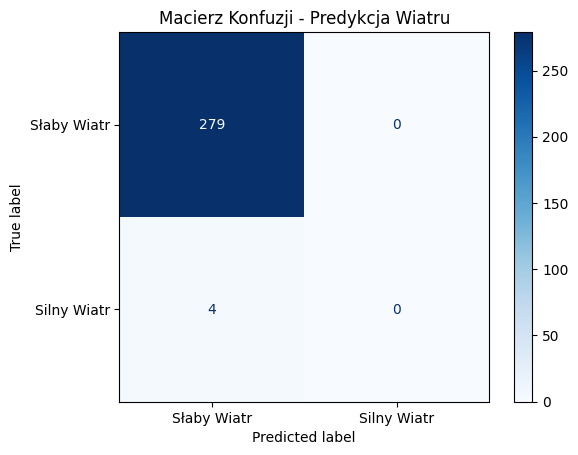

In [36]:
class TemperatureModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_temp):
        super(TemperatureModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_temp = nn.Linear(hidden_size, output_size_temp)  # Wyjście regresji dla temperatury

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        temp = self.fc2_temp(out)  # Predykcja temperatury
        return temp


class WindModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_wind):
        super(WindModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_wind = nn.Linear(hidden_size, output_size_wind)  # Wyjście klasyfikacyjne dla wiatru
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        wind = self.sigmoid(self.fc2_wind(out))  # Predykcja prawdopodobieństwa wiatru
        return wind

def train_model(temp_model, wind_model,
                X_train, y_temp_train, y_wind_train,
                X_val, y_temp_val, y_wind_val,
                criterion_temp, criterion_wind,
                optimizer_temp, optimizer_wind,
                num_epochs=100):
    # Historia strat treningowych i walidacyjnych
    history = {
        'train_loss_temp': [],
        'train_loss_wind': [],
        'val_loss_temp': [],
        'val_loss_wind': []
    }

    for epoch in range(num_epochs):
        # Trenowanie modelu dla temperatury
        temp_model.train()
        optimizer_temp.zero_grad()
        outputs_temp = temp_model(X_train)
        loss_temp = criterion_temp(outputs_temp.squeeze(), y_temp_train)
        loss_temp.backward()
        optimizer_temp.step()

        # Trenowanie modelu dla wiatru
        wind_model.train()
        optimizer_wind.zero_grad()
        outputs_wind = wind_model(X_train)
        loss_wind = criterion_wind(outputs_wind.squeeze(), y_wind_train)
        loss_wind.backward()
        optimizer_wind.step()

        # Walidacja
        temp_model.eval()
        wind_model.eval()
        with torch.no_grad():
            # Walidacja modelu temperatury
            val_outputs_temp = temp_model(X_val)
            val_loss_temp = criterion_temp(val_outputs_temp.squeeze(), y_temp_val)

            # Walidacja modelu wiatru
            val_outputs_wind = wind_model(X_val)
            val_loss_wind = criterion_wind(val_outputs_wind.squeeze(), y_wind_val)

        # Zapis strat do historii
        history['train_loss_temp'].append(loss_temp.item())
        history['train_loss_wind'].append(loss_wind.item())
        history['val_loss_temp'].append(val_loss_temp.item())
        history['val_loss_wind'].append(val_loss_wind.item())

        # Wyświetlanie postępu co 100 epok
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss - Temp: {loss_temp.item():.4f}, Wind: {loss_wind.item():.4f}")
            print(f"  Val Loss   - Temp: {val_loss_temp.item():.4f}, Wind: {val_loss_wind.item():.4f}")

    return history

# Trenowanie modeli dla Vancouver
city = 'Vancouver'

# Inicjalizacja modeli
temp_model = TemperatureModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1
)
wind_model = WindModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()  # Dla regresji temperatury
criterion_wind = nn.BCELoss()  # Dla klasyfikacji wiatru

# Definicja optymalizatorów
optimizer_temp = optim.Adam(temp_model.parameters(), lr=0.01)
optimizer_wind = optim.Adam(wind_model.parameters(), lr=0.01)

# Trenowanie modeli
history = train_model(
    temp_model,
    wind_model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer_temp,
    optimizer_wind,
    num_epochs=5000
)

# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz modele w tryb ewaluacji
temp_model.eval()
wind_model.eval()

with torch.no_grad():
    # Predykcje dla temperatury
    outputs_temp_test = temp_model(X_test_tensor)

    # Predykcje dla wiatru
    outputs_wind_test = wind_model(X_test_tensor)

# Konwersja wyników na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne dla wiatru (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

# Wizualizacja: Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(14, 6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnic i zaznaczenie punktów z różnicą >2°C
differences_temp = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences_temp > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura - MAE: {round(np.mean(differences_temp), 2)}°C')
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja: Macierz konfuzji dla klasyfikacji wiatru
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Słaby Wiatr', 'Silny Wiatr'])

disp.plot(cmap='Blues', values_format='d')
plt.title('Macierz Konfuzji - Predykcja Wiatru')
plt.show()

## 2.3 Architektura Sieci dla danych znormalizowanych

**Hipoteza**
Normalizacja danych wejściowych w przypadku oddzielnych sieci dla predykcji temperatury i wiatru zapewni lepsze wyniki niż wykorzystanie danych nieznormalizowanych.

**Opis**
Do weryfikacji hipotezy został wykorzystany model z badania poprzedniego dla danych nieznormalizowanych. Poniżej natomiast znajduje się model wyuczony na danych znormalizowanych.

**Wnioski**
Eksperyment potwierdził hipotezę. Oto kluczowe obserwacje:
1. **Temperatura (regresja):**
   Model na danych znormalizowanych osiągnął wyniki zbliżone do modelu z danymi nieznormalizowanymi

2. **Wiatr (klasyfikacja):**
   Normalizacja danych poprawiła proces uczenia się dla danych treningowych. Jednak model wykazywał gorszą skuteczność dla danych walidacyjnych.




Epoch [100/5000]
  Train Loss - Temp: 11742.8926, Wind: 0.0545
  Val Loss   - Temp: 12341.4131, Wind: 0.0713
Epoch [200/5000]
  Train Loss - Temp: 5061.9478, Wind: 0.0487
  Val Loss   - Temp: 5262.0820, Wind: 0.0805
Epoch [300/5000]
  Train Loss - Temp: 2030.6315, Wind: 0.0453
  Val Loss   - Temp: 2142.2371, Wind: 0.0889
Epoch [400/5000]
  Train Loss - Temp: 469.6486, Wind: 0.0426
  Val Loss   - Temp: 521.9717, Wind: 0.0917
Epoch [500/5000]
  Train Loss - Temp: 151.6720, Wind: 0.0393
  Val Loss   - Temp: 186.8891, Wind: 0.0911
Epoch [600/5000]
  Train Loss - Temp: 66.6450, Wind: 0.0350
  Val Loss   - Temp: 92.1381, Wind: 0.0886
Epoch [700/5000]
  Train Loss - Temp: 35.5877, Wind: 0.0305
  Val Loss   - Temp: 54.5646, Wind: 0.0933
Epoch [800/5000]
  Train Loss - Temp: 21.5470, Wind: 0.0257
  Val Loss   - Temp: 36.7902, Wind: 0.1089
Epoch [900/5000]
  Train Loss - Temp: 14.3907, Wind: 0.0225
  Val Loss   - Temp: 26.3933, Wind: 0.1218
Epoch [1000/5000]
  Train Loss - Temp: 10.2458, Wind: 0

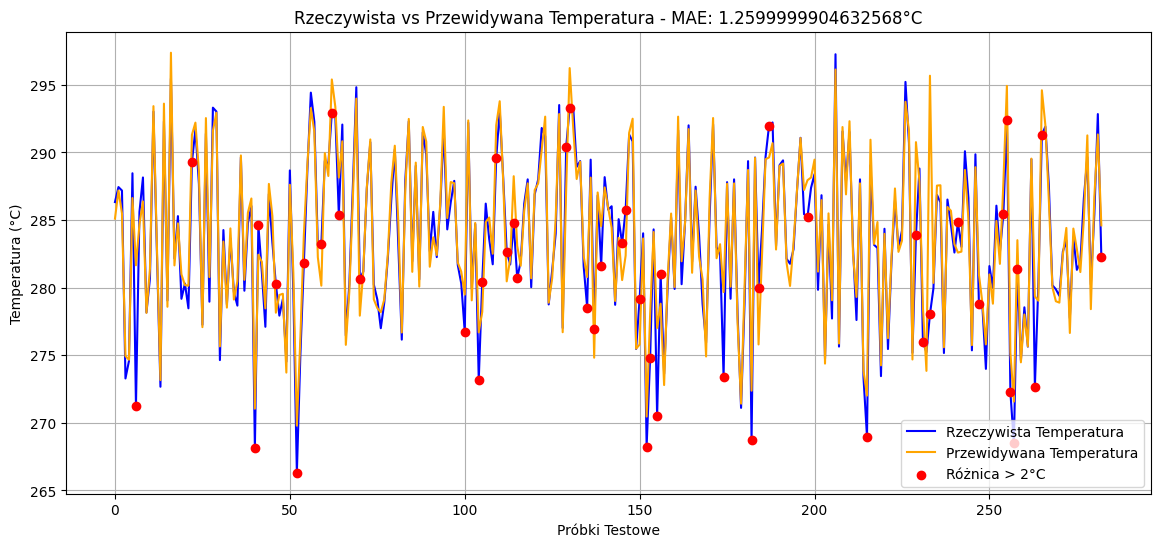

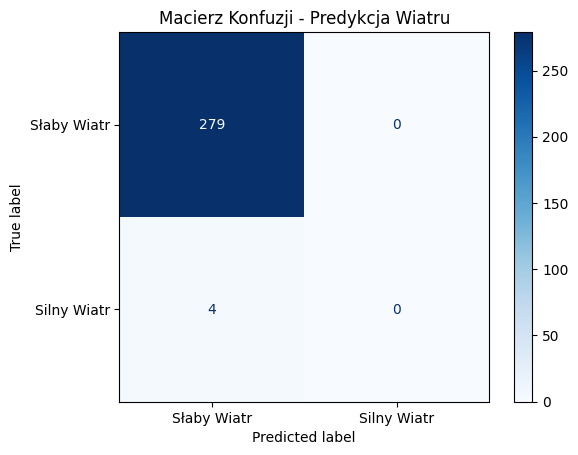

In [41]:
# Podział danych na zestawy treningowe, walidacyjne i testowe oraz normalizacja
for city, data in windows_dfs.items():
    X = data['X']
    y_temp = data['y_temp']
    y_wind = data['y_wind']

    # Podział danych na zestaw treningowy, walidacyjny i testowy
    X_train, X_temp_split, y_temp_train, y_temp_temp_split, y_wind_train, y_wind_temp_split = train_test_split(
        X, y_temp, y_wind, test_size=0.3, random_state=42, shuffle=True
    )

    X_val, X_test, y_temp_val, y_temp_test, y_wind_val, y_wind_test = train_test_split(
        X_temp_split, y_temp_temp_split, y_wind_temp_split, test_size=0.5, random_state=42, shuffle=True
    )

    # Normalizacja cech wejściowych
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Przekształcenie danych na tensory
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_temp_train_tensor = torch.tensor(y_temp_train, dtype=torch.float32)
    y_wind_train_tensor = torch.tensor(y_wind_train, dtype=torch.float32)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_temp_val_tensor = torch.tensor(y_temp_val, dtype=torch.float32)
    y_wind_val_tensor = torch.tensor(y_wind_val, dtype=torch.float32)

    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_temp_test_tensor = torch.tensor(y_temp_test, dtype=torch.float32)
    y_wind_test_tensor = torch.tensor(y_wind_test, dtype=torch.float32)

    # Aktualizacja słownika z normalizowanymi danymi i tensorami
    windows_dfs[city]['X_train'] = X_train_tensor
    windows_dfs[city]['X_val'] = X_val_tensor
    windows_dfs[city]['X_test'] = X_test_tensor
    windows_dfs[city]['y_temp_train'] = y_temp_train_tensor
    windows_dfs[city]['y_temp_val'] = y_temp_val_tensor
    windows_dfs[city]['y_temp_test'] = y_temp_test_tensor
    windows_dfs[city]['y_wind_train'] = y_wind_train_tensor
    windows_dfs[city]['y_wind_val'] = y_wind_val_tensor
    windows_dfs[city]['y_wind_test'] = y_wind_test_tensor
    windows_dfs[city]['scaler'] = scaler

class TemperatureModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_temp):
        super(TemperatureModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_temp = nn.Linear(hidden_size, output_size_temp)  # Wyjście regresji dla temperatury

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        temp = self.fc2_temp(out)  # Predykcja temperatury
        return temp


class WindModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_wind):
        super(WindModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2_wind = nn.Linear(hidden_size, output_size_wind)  # Wyjście klasyfikacyjne dla wiatru
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        wind = self.sigmoid(self.fc2_wind(out))  # Predykcja prawdopodobieństwa wiatru
        return wind

def train_model(temp_model, wind_model,
                X_train, y_temp_train, y_wind_train,
                X_val, y_temp_val, y_wind_val,
                criterion_temp, criterion_wind,
                optimizer_temp, optimizer_wind,
                num_epochs=100):
    # Historia strat treningowych i walidacyjnych
    history = {
        'train_loss_temp': [],
        'train_loss_wind': [],
        'val_loss_temp': [],
        'val_loss_wind': []
    }

    for epoch in range(num_epochs):
        # Trenowanie modelu dla temperatury
        temp_model.train()
        optimizer_temp.zero_grad()
        outputs_temp = temp_model(X_train)
        loss_temp = criterion_temp(outputs_temp.squeeze(), y_temp_train)
        loss_temp.backward()
        optimizer_temp.step()

        # Trenowanie modelu dla wiatru
        wind_model.train()
        optimizer_wind.zero_grad()
        outputs_wind = wind_model(X_train)
        loss_wind = criterion_wind(outputs_wind.squeeze(), y_wind_train)
        loss_wind.backward()
        optimizer_wind.step()

        # Walidacja
        temp_model.eval()
        wind_model.eval()
        with torch.no_grad():
            # Walidacja modelu temperatury
            val_outputs_temp = temp_model(X_val)
            val_loss_temp = criterion_temp(val_outputs_temp.squeeze(), y_temp_val)

            # Walidacja modelu wiatru
            val_outputs_wind = wind_model(X_val)
            val_loss_wind = criterion_wind(val_outputs_wind.squeeze(), y_wind_val)

        # Zapis strat do historii
        history['train_loss_temp'].append(loss_temp.item())
        history['train_loss_wind'].append(loss_wind.item())
        history['val_loss_temp'].append(val_loss_temp.item())
        history['val_loss_wind'].append(val_loss_wind.item())

        # Wyświetlanie postępu co 100 epok
        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"  Train Loss - Temp: {loss_temp.item():.4f}, Wind: {loss_wind.item():.4f}")
            print(f"  Val Loss   - Temp: {val_loss_temp.item():.4f}, Wind: {val_loss_wind.item():.4f}")

    return history

# Trenowanie modeli dla Vancouver
city = 'Vancouver'

# Inicjalizacja modeli
temp_model = TemperatureModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1
)
wind_model = WindModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()  # Dla regresji temperatury
criterion_wind = nn.BCELoss()  # Dla klasyfikacji wiatru

# Definicja optymalizatorów
optimizer_temp = optim.Adam(temp_model.parameters(), lr=0.01)
optimizer_wind = optim.Adam(wind_model.parameters(), lr=0.01)

# Trenowanie modeli
history = train_model(
    temp_model,
    wind_model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer_temp,
    optimizer_wind,
    num_epochs=5000
)

# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz modele w tryb ewaluacji
temp_model.eval()
wind_model.eval()

with torch.no_grad():
    # Predykcje dla temperatury
    outputs_temp_test = temp_model(X_test_tensor)

    # Predykcje dla wiatru
    outputs_wind_test = wind_model(X_test_tensor)

# Konwersja wyników na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne dla wiatru (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

# Wizualizacja: Rzeczywista vs Przewidywana Temperatura
plt.figure(figsize=(14, 6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnic i zaznaczenie punktów z różnicą >2°C
differences_temp = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences_temp > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura - MAE: {round(np.mean(differences_temp), 2)}°C')
plt.legend()
plt.grid(True)
plt.show()

# Wizualizacja: Macierz konfuzji dla klasyfikacji wiatru
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_wind_test_np, y_wind_pred_np)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Słaby Wiatr', 'Silny Wiatr'])

disp.plot(cmap='Blues', values_format='d')
plt.title('Macierz Konfuzji - Predykcja Wiatru')
plt.show()

## 2.4 Funkcje aktywacji

**Hipoteza**:
Wykorzystanie funkcji ReLU w warstwach ukrytych zapewni szybszą zbieżność niż funkcja tanh, co może przełożyć się na lepsze wyniki uczenia modelu.

**Opis**:
W pierwotnym modelu zastosowano funkcję aktywacji **ReLU** w warstwach ukrytych. W celu przetestowania hipotezy funkcję tę zastąpiono **tanh**. Model z funkcją tanh został przetestowany w tych samych warunkach (architektura, dane, liczba epok), co pozwala na bezpośrednie porównanie wyników.

**Wnioski**:
Model z funkcją tanh osiągnął **gorszy wynik** niż model z funkcją ReLU. Różnica była szczególnie widoczna w tempie redukcji błędu podczas uczenia – zbieżność była wolniejsza dla tanh.


Epoch [100/5000], Loss: 46659.4258, Val Loss: 46186.1367
Epoch [200/5000], Loss: 20026.1484, Val Loss: 19798.4336
Epoch [300/5000], Loss: 8098.3003, Val Loss: 7985.9722
Epoch [400/5000], Loss: 2929.6323, Val Loss: 2877.3176
Epoch [500/5000], Loss: 935.4003, Val Loss: 912.9056
Epoch [600/5000], Loss: 271.4632, Val Loss: 262.4638
Epoch [700/5000], Loss: 79.9300, Val Loss: 76.3901
Epoch [800/5000], Loss: 29.2476, Val Loss: 27.6722
Epoch [900/5000], Loss: 16.8251, Val Loss: 15.9842
Epoch [1000/5000], Loss: 12.9564, Val Loss: 12.4222
Epoch [1100/5000], Loss: 11.2081, Val Loss: 11.5277
Epoch [1200/5000], Loss: 10.5329, Val Loss: 11.2520
Epoch [1300/5000], Loss: 9.9632, Val Loss: 10.8507
Epoch [1400/5000], Loss: 9.2237, Val Loss: 10.0110
Epoch [1500/5000], Loss: 8.4509, Val Loss: 8.4925
Epoch [1600/5000], Loss: 7.8160, Val Loss: 7.9170
Epoch [1700/5000], Loss: 7.5449, Val Loss: 8.2226
Epoch [1800/5000], Loss: 7.3368, Val Loss: 8.5386
Epoch [1900/5000], Loss: 7.2085, Val Loss: 8.6684
Epoch [20

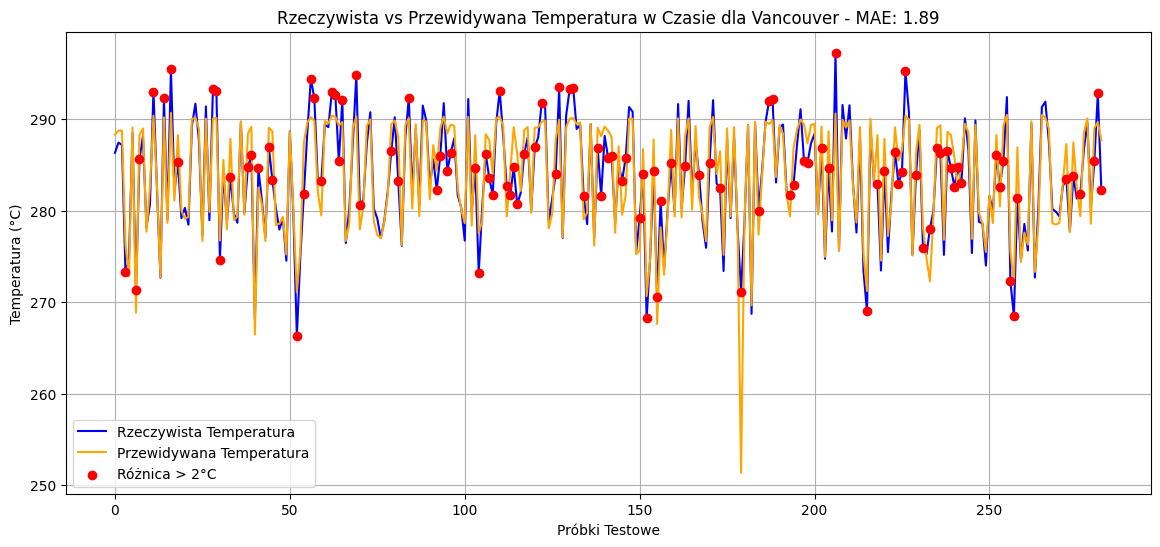

In [58]:
class WeatherModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size_temp, output_size_wind):
        super(WeatherModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()  # Zmieniono funkcję aktywacji na tanh
        self.fc2_temp = nn.Linear(hidden_size, output_size_temp)  # Dla temperatury (regresja)
        self.fc2_wind = nn.Linear(hidden_size, output_size_wind)  # Dla wiatru (klasyfikacja)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)  # Zastosowano funkcję tanh
        temp = self.fc2_temp(out)
        wind = self.sigmoid(self.fc2_wind(out))
        return temp, wind

# Definicja funkcji trenowania modelu
def train_model(model, X_train, y_temp_train, y_wind_train,
               X_val, y_temp_val, y_wind_val,
               criterion_temp, criterion_wind, optimizer,
               num_epochs=100):
    history = {'train_loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs_temp, outputs_wind = model(X_train)

        loss_temp = criterion_temp(outputs_temp.squeeze(), y_temp_train)
        loss_wind = criterion_wind(outputs_wind.squeeze(), y_wind_train)

        loss = loss_temp + loss_wind
        loss.backward()
        optimizer.step()

        # Walidacja
        model.eval()
        with torch.no_grad():
            val_outputs_temp, val_outputs_wind = model(X_val)
            val_loss_temp = criterion_temp(val_outputs_temp.squeeze(), y_temp_val)
            val_loss_wind = criterion_wind(val_outputs_wind.squeeze(), y_wind_val)
            val_loss = val_loss_temp + val_loss_wind

        history['train_loss'].append(loss.item())
        history['val_loss'].append(val_loss.item())

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

    return history

# Trenowanie modelu dla Vancouver
city = 'Vancouver'
model = WeatherModel(
    input_size=windows_dfs[city]['X_train'].shape[1],
    hidden_size=64,
    output_size_temp=1,
    output_size_wind=1
)

# Definicja funkcji strat
criterion_temp = nn.MSELoss()
criterion_wind = nn.BCELoss()

# Definicja optymalizatora
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Trenowanie modelu
history = train_model(
    model,
    windows_dfs[city]['X_train'],
    windows_dfs[city]['y_temp_train'],
    windows_dfs[city]['y_wind_train'],
    windows_dfs[city]['X_val'],
    windows_dfs[city]['y_temp_val'],
    windows_dfs[city]['y_wind_val'],
    criterion_temp,
    criterion_wind,
    optimizer,
    num_epochs=5000
)

# Wizualizacje dla Vancouver
city = 'Vancouver'
vancouver_data = windows_dfs[city]

# Uzyskanie zestawu testowego
X_test_tensor = vancouver_data['X_test']
y_temp_test_tensor = vancouver_data['y_temp_test']
y_wind_test_tensor = vancouver_data['y_wind_test']

# Przełącz model w tryb ewaluacji
model.eval()
with torch.no_grad():
    outputs_temp_test, outputs_wind_test = model(X_test_tensor)

# Konwersja na NumPy
y_temp_test_np = y_temp_test_tensor.numpy()
outputs_temp_test_np = outputs_temp_test.squeeze().numpy()

y_wind_test_np = y_wind_test_tensor.numpy()
outputs_wind_test_np = outputs_wind_test.squeeze().numpy()

# Predykcje klasyfikacyjne (próg 0.5)
y_wind_pred_np = (outputs_wind_test_np >= 0.5).astype(int)

# Wykres Temperatura w Czasie z zaznaczeniem różnic >2°C
plt.figure(figsize=(14,6))
plt.plot(y_temp_test_np, label='Rzeczywista Temperatura', color='blue')
plt.plot(outputs_temp_test_np, label='Przewidywana Temperatura', color='orange')

# Obliczenie różnicy i zaznaczenie punktów z wysokoą różnicą
differences = np.abs(y_temp_test_np - outputs_temp_test_np)
mask_high_diff = differences > 2
plt.scatter(np.where(mask_high_diff)[0], y_temp_test_np[mask_high_diff],
            color='red', label='Różnica > 2°C', zorder=5)

plt.xlabel('Próbki Testowe')
plt.ylabel('Temperatura (°C)')
plt.title(f'Rzeczywista vs Przewidywana Temperatura w Czasie dla Vancouver - MAE: {round(sum(differences)/len(differences), 2)}')
plt.legend()
plt.grid(True)
plt.show()

# 3. Wnioski

Podsumowując wyniki analiz przeprowadzonych w ramach testowania wszystkich hipotez badawczych, można wyciągnąć następujące wnioski:

---

### **1. Kodowanie danych**
- **Normalizacja danych**: Zastosowanie normalizacji danych wejściowych do przedziału [-1, 1] miało ograniczony wpływ na predykcję temperatury, gdzie modele osiągnęły porównywalne wyniki na danych znormalizowanych i nieznormalizowanych. Jednak w przypadku klasyfikacji wiatru normalizacja poprawiła wyniki, ułatwiając modelowi rozróżnienie klas.

---

### **2. Architektura sieci**
- **Oddzielne modele dla temperatury i wiatru**: Rozdzielenie modelu na dwa niezależne (jeden dla regresji temperatury, drugi dla klasyfikacji wiatru) nie wpłynęło znacząco na optymalizację dla każdego zadania.

---

### **3. Architektura sieci dla danych znormalizowanych**
- Normalizacja danych wejściowych nie wpłynęła znacząco na proces nauki przewidywania temperatury. Model przeiwdywania wiatru zaczął się dostowywać do danych treningowych co poprawiało klasyfikację danych trenignowych, ale pogarszało testy walidacyjne.

---

### **4. Funkcje aktywacji**
- **ReLU vs Tanh**:
  - Funkcja ReLU okazała się bardziej efektywna, zapewniając szybszą zbieżność i lepsze wyniki zarówno w regresji temperatury, jak i klasyfikacji wiatru.
  - Funkcja tanh była mniej skuteczna, szczególnie w głębszych warstwach, co można przypisać problemowi zanikających gradientów.
